In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
import pickle
from matplotlib import cm
import pylab
from PIL import Image
from matplotlib.pyplot import imshow

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 

In [3]:
import keras
from keras import layers, regularizers,optimizers,callbacks,applications
from keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import SGD,Adam
from keras.layers import Dropout,Conv2D,MaxPool2D
from keras import models

In [4]:
label_match=pd.read_csv('label_match.csv')
label_match['code']=label_match.code.astype(str).str.zfill(8)
label_match = dict(zip(label_match.code, label_match.label))

In [5]:
img_dir =r'spec_images/spec_images/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 8
NUM_EPOCHS = 10
BATCH_SIZE = 128
L2_LAMBDA = 0.001

In [6]:
all_files=[f for f in os.listdir(img_dir) if not f.startswith('.')]

label_dict = {'Electronic':0,'Experimental':1,'Folk':2,'Hip-Hop':3,'Instrumental':4,
              'International':5,'Pop':6,'Rock':7 }

In [7]:
label_array = []
for file_ in all_files:
    if file_.endswith(".jpg"):
        vals = file_[:-4]
        lab=label_match[vals]
        label_array.append(label_dict[lab])
        
label_array=np.array(label_array).reshape(-1, 1)
one_hot = OneHotEncoder()

In [8]:
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1)

val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5)

In [9]:
train_files,train_labels=shuffle(train_files,train_labels)

In [10]:
model = Sequential()
model.add(layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))) # Flatten output and send it to MLP # 3 channel - RGB

model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(32, name='dense_2', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_2')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_2'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 139968)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               71664128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0

In [11]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        if file_.endswith(".jpg"):
            im = Image.open(img_dir + file_)
            im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            img_array.append(np.array(im))

            vals = file_[:-4]
            idx_array.append(vals)
            lab=label_match[vals]
            label_array.append(label_dict[lab])
    
    label_array=np.array(label_array).reshape(-1,1)
    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [12]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)
            if batch_label_array.shape[1]==8: 
                yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [13]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/feed_forward_baseline_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
val_steps = len(val_files)//BATCH_SIZE

history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              #class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = val_steps, 
                              callbacks = callbacks_list,
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
224/224 [==============================] - 283s 1s/step - loss: 3.0606 - categorical_accuracy: 0.1935 - val_loss: 2.9055 - val_categorical_accuracy: 0.2598
Epoch 2/10
224/224 [==============================] - 272s 1s/step - loss: 2.8693 - categorical_accuracy: 0.2510 - val_loss: 2.7543 - val_categorical_accuracy: 0.3053
Epoch 3/10
224/224 [==============================] - 274s 1s/step - loss: 2.7512 - categorical_accuracy: 0.2712 - val_loss: 2.6453 - val_categorical_accuracy: 0.3216
Epoch 4/10
224/224 [==============================] - 275s 1s/step - loss: 2.6627 - categorical_accuracy: 0.2810 - val_loss: 2.5890 - val_categorical_accuracy: 0.3132
Epoch 5/10
224/224 [==============================] - 275s 1s/step - loss: 2.5892 - categorical_accuracy: 0.2933 - val_loss: 2.5127 - val_categorical_accuracy: 0.3236
Epoch 6/10
224/224 [==============================] - 275s 1s/step - loss: 2.5182 - categ

In [15]:
#Save scores on train and validation sets
with open('pickle_files/feed_forward_baseline_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [16]:
# Load scores
with open('pickle_files/feed_forward_baseline_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


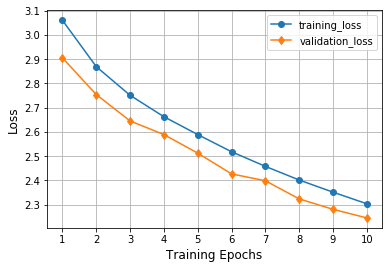

In [17]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

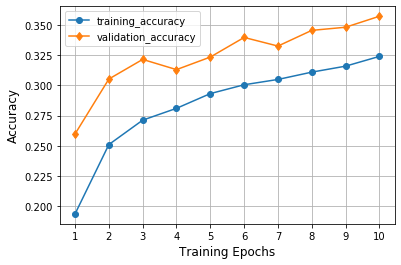

In [18]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [20]:
model = models.load_model('saved_models/feed_forward_baseline_epoch_10_0.3574.h5')

In [21]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[ 38   6  22  87  12  11   8   8]
 [  9  31  48  32  25  22  11  16]
 [  2   8 127   9  25  12  12   9]
 [ 16   1  16 125   6  10  11   6]
 [  4   7  73  15  58  13  10  10]
 [  8   6  38  45  22  60  13   6]
 [ 10   6  38  29  17  22  26  36]
 [  5   9  38  21   3   8  13  86]]


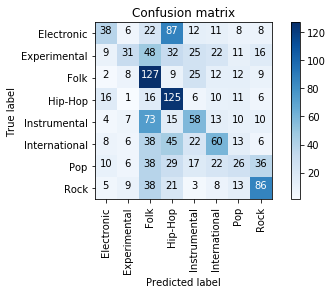

In [25]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), classes=label_dict.keys())